<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models with Miscellaneous Box Stats Features</h4>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Baseline-Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Training Windows](#Inspect-Training-Windows)

- [Expanding](#Expanding)

- [Rolling](#Rolling)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

- [1.1. Expanding Window](#1.1.-Expanding-Window)

- [1.2. Rolling Window](#1.2.-Rolling-Window)

**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

- [2.1. Expanding Window](#2.1.-Expanding-Window)

- [2.2. Rolling Window](#2.2.-Rolling-Window)

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

- [3.1. Expanding Window](#3.1.-Expanding-Window)

- [3.2. Rolling Window](#3.2.-Rolling-Window)

# Setup

[Return to top](#Baseline-Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

# Data

[Return to top](#Baseline-Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df, test_set_obs = utl.load_and_scale_data(
    file_path='../../data/processed/nba_team_matchups_rolling_misc_box_stats_2021_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefix='ROLL_',
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [4]:
pts_scaled_df.tail()

,ROLL_HOME_PTS_OFF_TOV,ROLL_HOME_PTS_2ND_CHANCE,ROLL_HOME_PTS_FB,ROLL_HOME_PTS_PAINT,ROLL_HOME_OPP_PTS_OFF_TOV,ROLL_HOME_OPP_PTS_2ND_CHANCE,ROLL_HOME_OPP_PTS_FB,ROLL_HOME_OPP_PTS_PAINT,ROLL_HOME_BLK,ROLL_HOME_BLKA,ROLL_HOME_PF,ROLL_HOME_PFD,ROLL_HOME_PTS,ROLL_AWAY_PTS_OFF_TOV,ROLL_AWAY_PTS_2ND_CHANCE,ROLL_AWAY_PTS_FB,ROLL_AWAY_PTS_PAINT,ROLL_AWAY_OPP_PTS_OFF_TOV,ROLL_AWAY_OPP_PTS_2ND_CHANCE,ROLL_AWAY_OPP_PTS_FB,ROLL_AWAY_OPP_PTS_PAINT,ROLL_AWAY_BLK,ROLL_AWAY_BLKA,ROLL_AWAY_PF,ROLL_AWAY_PFD,ROLL_AWAY_PTS,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-03,14.8,14.2,19.4,54.0,19.4,14.2,13.2,58.0,7.6,5.0,15.6,17.0,110.6,15.8,11.2,16.4,46.0,17.6,10.4,12.4,42.4,5.6,4.6,18.4,18.2,115.6,218
2024-02-04,13.8,11.0,15.4,56.8,18.6,17.8,17.8,60.8,6.6,5.6,20.6,18.2,106.0,13.2,12.8,16.2,52.0,18.0,18.6,15.2,54.8,5.8,4.0,16.2,18.6,120.6,252
2024-02-04,12.6,13.0,10.2,50.0,17.0,15.8,14.0,53.6,4.4,5.4,18.2,20.4,115.0,21.0,16.4,15.8,52.0,12.4,10.6,13.0,50.0,4.4,5.0,21.2,20.4,111.0,210
2024-02-04,15.2,10.8,15.4,48.0,17.6,13.2,10.8,61.2,6.4,6.4,19.8,15.8,103.4,13.6,15.8,12.0,49.6,15.0,12.0,14.8,58.0,5.4,7.6,22.4,19.0,116.0,214
2024-02-04,12.2,13.8,14.2,41.6,10.4,16.4,10.2,49.6,6.8,3.2,16.4,14.2,113.8,14.6,11.6,14.8,44.8,17.8,14.2,16.0,52.4,5.8,7.4,18.0,17.6,104.4,222


In [5]:
pm_scaled_df.head()

,ROLL_HOME_PTS_OFF_TOV,ROLL_HOME_PTS_2ND_CHANCE,ROLL_HOME_PTS_FB,ROLL_HOME_PTS_PAINT,ROLL_HOME_OPP_PTS_OFF_TOV,ROLL_HOME_OPP_PTS_2ND_CHANCE,ROLL_HOME_OPP_PTS_FB,ROLL_HOME_OPP_PTS_PAINT,ROLL_HOME_BLK,ROLL_HOME_BLKA,ROLL_HOME_PF,ROLL_HOME_PFD,ROLL_HOME_PTS,ROLL_AWAY_PTS_OFF_TOV,ROLL_AWAY_PTS_2ND_CHANCE,ROLL_AWAY_PTS_FB,ROLL_AWAY_PTS_PAINT,ROLL_AWAY_OPP_PTS_OFF_TOV,ROLL_AWAY_OPP_PTS_2ND_CHANCE,ROLL_AWAY_OPP_PTS_FB,ROLL_AWAY_OPP_PTS_PAINT,ROLL_AWAY_BLK,ROLL_AWAY_BLKA,ROLL_AWAY_PF,ROLL_AWAY_PFD,ROLL_AWAY_PTS,PLUS_MINUS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,9.0,11.0,2.0,58.0,18.0,12.0,20.0,46.0,5.0,4.0,22.0,22.0,121.0,15.0,5.0,5.0,52.0,19.0,11.0,5.0,26.0,2.0,3.0,22.0,26.0,115.0,29.0
2021-10-23,38.0,15.0,31.0,50.0,21.0,17.0,13.0,58.0,12.0,3.0,22.0,25.0,124.0,21.0,10.0,16.0,44.0,27.0,18.0,24.0,54.0,5.0,7.0,20.0,14.0,112.0,7.0
2021-10-23,21.0,19.0,26.0,58.0,7.0,20.0,6.0,50.0,3.0,6.0,22.0,20.0,123.0,5.0,3.0,2.0,38.0,21.0,15.0,22.0,60.0,0.0,2.0,26.0,26.0,95.0,-10.0
2021-10-23,17.0,11.0,18.0,40.0,18.0,11.0,8.0,56.0,4.0,8.0,21.0,17.0,83.0,14.0,2.0,7.0,26.0,9.0,8.0,11.0,46.0,3.0,9.0,21.0,16.0,87.0,-8.0
2021-10-24,21.0,21.0,17.0,58.0,14.0,11.0,13.0,34.0,10.0,4.0,18.0,21.0,124.0,17.0,9.0,19.0,42.0,17.0,14.0,14.0,60.0,9.0,10.0,24.0,22.0,134.0,-10.0


In [6]:
res_scaled_df.tail()

,ROLL_HOME_PTS_OFF_TOV,ROLL_HOME_PTS_2ND_CHANCE,ROLL_HOME_PTS_FB,ROLL_HOME_PTS_PAINT,ROLL_HOME_OPP_PTS_OFF_TOV,ROLL_HOME_OPP_PTS_2ND_CHANCE,ROLL_HOME_OPP_PTS_FB,ROLL_HOME_OPP_PTS_PAINT,ROLL_HOME_BLK,ROLL_HOME_BLKA,ROLL_HOME_PF,ROLL_HOME_PFD,ROLL_HOME_PTS,ROLL_AWAY_PTS_OFF_TOV,ROLL_AWAY_PTS_2ND_CHANCE,ROLL_AWAY_PTS_FB,ROLL_AWAY_PTS_PAINT,ROLL_AWAY_OPP_PTS_OFF_TOV,ROLL_AWAY_OPP_PTS_2ND_CHANCE,ROLL_AWAY_OPP_PTS_FB,ROLL_AWAY_OPP_PTS_PAINT,ROLL_AWAY_BLK,ROLL_AWAY_BLKA,ROLL_AWAY_PF,ROLL_AWAY_PFD,ROLL_AWAY_PTS,GAME_RESULT
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-03,14.8,14.2,19.4,54.0,19.4,14.2,13.2,58.0,7.6,5.0,15.6,17.0,110.6,15.8,11.2,16.4,46.0,17.6,10.4,12.4,42.4,5.6,4.6,18.4,18.2,115.6,0
2024-02-04,13.8,11.0,15.4,56.8,18.6,17.8,17.8,60.8,6.6,5.6,20.6,18.2,106.0,13.2,12.8,16.2,52.0,18.0,18.6,15.2,54.8,5.8,4.0,16.2,18.6,120.6,0
2024-02-04,12.6,13.0,10.2,50.0,17.0,15.8,14.0,53.6,4.4,5.4,18.2,20.4,115.0,21.0,16.4,15.8,52.0,12.4,10.6,13.0,50.0,4.4,5.0,21.2,20.4,111.0,0
2024-02-04,15.2,10.8,15.4,48.0,17.6,13.2,10.8,61.2,6.4,6.4,19.8,15.8,103.4,13.6,15.8,12.0,49.6,15.0,12.0,14.8,58.0,5.4,7.6,22.4,19.0,116.0,0
2024-02-04,12.2,13.8,14.2,41.6,10.4,16.4,10.2,49.6,6.8,3.2,16.4,14.2,113.8,14.6,11.6,14.8,44.8,17.8,14.2,16.0,52.4,5.8,7.4,18.0,17.6,104.4,1


# Inspect Training Windows

[Return to top](#Baseline-Models)

## Expanding

[Return to top](#Baseline-Models)

In [7]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
gap_size=0               # should there be a gap between train and test sets?
expansion_limit=None     # the limit on the test set observations

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, 
                                                                 test_size=test_size, gap_size=gap_size,
                                                                 expansion_limit=expansion_limit):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

## Rolling

[Return to top](#Baseline-Models)

In [8]:
# expanding window configuration
train_size = 10 # size of training set window
test_size = 1   # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

for train_index, test_index in utl.rolling_window_ts_split(pts_scaled_df, train_size, test_size):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [14 15 16 17 18 19 20 21 22 23] TEST: [24]


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="1.1.-Expanding-Window"></a>
## 1.1. Expanding Window

[Return to top](#Baseline-Models)

In [9]:
# configuration for total points with expanding window
model = LinearRegression()  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
lr, model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    fitted_model=True
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 10.40 seconds


In [10]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.32
- Null RMSE: 20.28


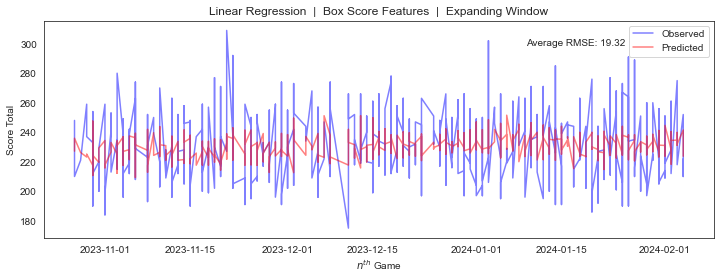

In [11]:
utl.plot_model_performance(
    title='Linear Regression  |  Box Score Features  |  Expanding Window',
    y_label='Score Total',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="1.2.-Rolling-Window"></a>
## 1.2. Rolling Window

[Return to top](#Baseline-Models)

In [12]:
# configuration for total points with rolling window
model = LinearRegression()  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit
)

Total time taken: 26.27 seconds


In [13]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.39
- Null RMSE: 19.88


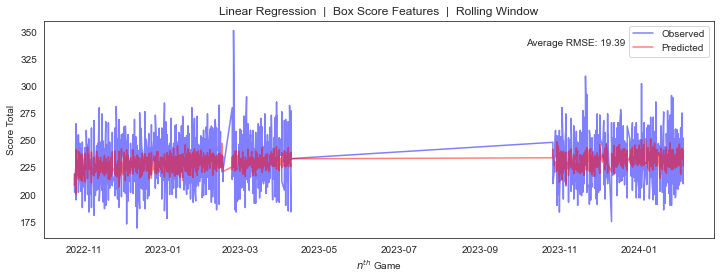

In [14]:
utl.plot_model_performance_rolling(
    title='Linear Regression  |  Box Score Features  |  Rolling Window',
    y_label='Score Total',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    train_size=train_size
)

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)

<a name="2.1.-Expanding-Window"></a>
## 2.1. Expanding Window

[Return to top](#Baseline-Models)

In [15]:
# configuration for point difference with expanding window
model = LinearRegression()  # model class
target_col = 'PLUS_MINUS'   # target column name
df = pm_scaled_df           # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 11.17 seconds


In [17]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 14.38
- Null RMSE: 15.32


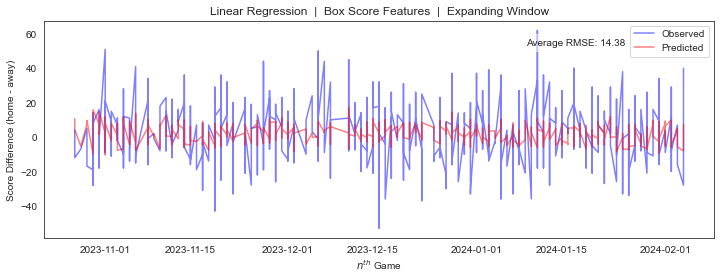

In [18]:
utl.plot_model_performance(
    title='Linear Regression  |  Box Score Features  |  Expanding Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="2.2.-Rolling-Window"></a>
## 2.2. Rolling Window

[Return to top](#Baseline-Models)

In [19]:
# configuration for points difference with rolling window
model = LinearRegression()  # model class
target_col = 'PLUS_MINUS'   # target column name
df = pm_scaled_df           # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit
)

Total time taken: 26.09 seconds


In [20]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 13.84
- Null RMSE: 14.28


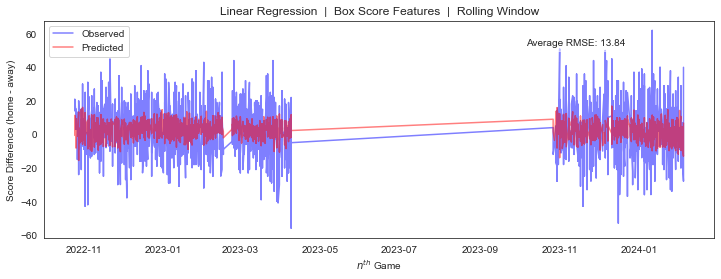

In [21]:
utl.plot_model_performance_rolling(
    title='Linear Regression  |  Box Score Features  |  Rolling Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    train_size=train_size
)

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Baseline-Models)

<a name="3.1.-Expanding-Window"></a>
## 3.1. Expanding Window

[Return to top](#Baseline-Models)

In [22]:
# configuration for game winner with expanding window
model = LogisticRegression(penalty=None, max_iter=10000, solver='lbfgs')  # model class
target_col = 'GAME_RESULT'  # target column name
df = res_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    ensure_diversity=True # ensure class diversity in training
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 84.47 seconds


In [23]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Average Accuracy: 0.63
- Overall AUC: 0.68
- Average F1 Score: 0.69


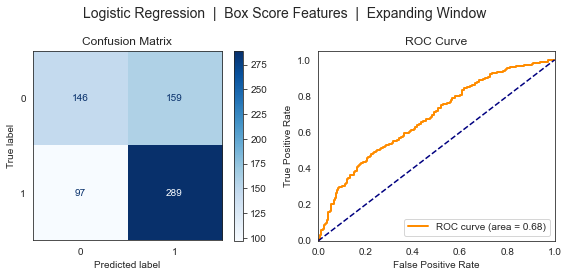

In [24]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Logistic Regression  |  Box Score Features  |  Expanding Window'
)

In [25]:
# write out all model predictions and meta-data
test_set_obs.rename(columns={
    'TOTAL_PTS': 'TOTAL_PTS_PREDS',
    'PLUS_MINUS': 'PLUS_MINUS_PREDS',
    'GAME_RESULT': 'GAME_RESULT_PREDS'
}, inplace=True)
columns_to_round = ['TOTAL_PTS_PREDS', 'PLUS_MINUS_PREDS', 'GAME_RESULT_PREDS']
test_set_obs[columns_to_round] = test_set_obs[columns_to_round].round(4)
test_set_obs.to_csv('../../data/model_predictions/GLM_preds_misc_box_stats.csv', index=False)

<a name="3.2.-Rolling-Window"></a>
## 3.2. Rolling Window

[Return to top](#Baseline-Models)

In [26]:
# configuration for game winner with rolling window
model = LogisticRegression(penalty=None, max_iter=10000, solver='lbfgs')  # model class
target_col = 'GAME_RESULT'  # target column name
df = res_scaled_df          # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit,
    ensure_diversity=True # ensure class diversity in training
)

Total time taken: 195.33 seconds


In [27]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Average Accuracy: 0.61
- Overall AUC: 0.63
- Average F1 Score: 0.69


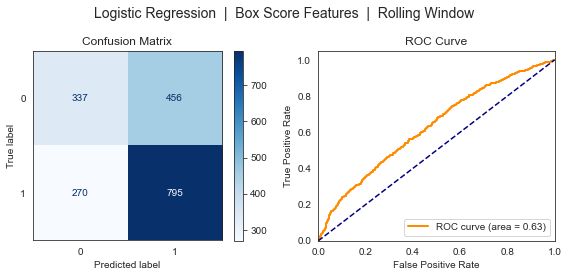

In [28]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Logistic Regression  |  Box Score Features  |  Rolling Window'
)